In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Gernerate some data

In [6]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

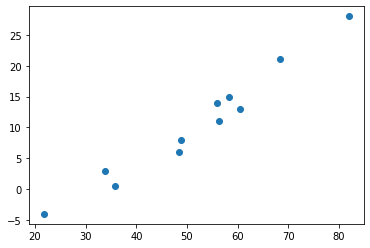

In [8]:
plt.scatter(t_u, t_c)
plt.show()

### Predict and loss function

In [9]:
def model(t_u, w, b):
    return w * t_u + b

def loss_fn(t_p, t_c):
    square_diff = (t_p - t_c) ** 2
    return square_diff.mean()


### Invoke the model

In [13]:
w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
t_p, t_p.shape

(tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
         48.4000, 60.4000, 68.4000]),
 torch.Size([11]))

In [14]:
loss = loss_fn(t_p, t_c)
loss, loss.shape

(tensor(1763.8848), torch.Size([]))

### Gradient function

In [17]:
def dloss_fn(t_p, t_c):
    dsq_diff = 2 * (t_p - t_c) / t_p.size(0)
    return dsq_diff

def dmodel_dw(t_u, w, b):
    return t_u

def dmodel_db(t_u, w, b):
    return 1.0

def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])

### Training

In [20]:
def training_loops(n_epochs, learning_rate, params, t_u, t_c):
    for i in range(1, n_epochs + 1):
        w, b = params
        
        t_p = model(t_u, w, b) # forward
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b) # backward
        
        params -= learning_rate * grad
        if i % 10 == 0:
            print(f"Epochs {i} loss {loss}%")
    
    return params

In [21]:
training_loops(n_epochs=100, learning_rate=1e-4, params=torch.tensor([1.0, 0.0]), t_u=t_u, t_c=t_c)

Epochs 10 loss 29.105247497558594%
Epochs 20 loss 29.09588050842285%
Epochs 30 loss 29.086713790893555%
Epochs 40 loss 29.07756233215332%
Epochs 50 loss 29.068401336669922%
Epochs 60 loss 29.059247970581055%
Epochs 70 loss 29.050098419189453%
Epochs 80 loss 29.04095458984375%
Epochs 90 loss 29.031810760498047%
Epochs 100 loss 29.022666931152344%


tensor([ 0.2327, -0.0438])

### PyTorch autograd

In [23]:
params = torch.tensor([1.0, 0.0], requires_grad=True)

In [24]:
loss = loss_fn(model(t_u, *params), t_c)
loss.backward()

params.grad

tensor([4517.2969,   82.6000])

In [25]:
def training_loop_2(n_epochs, learning_rate, params, t_u, t_c):
    for i in range(1, n_epochs + 1):
        if params.grad is not None:
            params.grad.zero_()
        
        t_p = model(t_u, *params) # forward
        loss = loss_fn(t_p, t_c)
        loss.backward()
#         grad = grad_fn(t_u, t_c, t_p, w, b) # backward

        with torch.no_grad():
            params -= learning_rate * params.grad

        if i % 100 == 0:
            print(f"Epochs {i} loss {loss}%")
    
    return params

In [27]:
training_loop_2(500, 1e-2, torch.tensor([1.0, 0.0], requires_grad=True), t_u*0.1, t_c)

Epochs 100 loss 22.148710250854492%
Epochs 200 loss 16.60806655883789%
Epochs 300 loss 12.664559364318848%
Epochs 400 loss 9.857802391052246%
Epochs 500 loss 7.860115051269531%


tensor([ 4.0443, -9.8133], requires_grad=True)

### PyTorch optimzer

In [28]:
import torch.optim as optim

In [29]:
dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'Optimizer',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional',
 '_multi_tensor',
 'lr_scheduler',
 'swa_utils']

In [36]:
def training_loop_3(n_epochs, optimzer, params, t_u, t_c):
    for i in range(1, n_epochs + 1):        
        t_p = model(t_u, *params) # forward
        loss = loss_fn(t_p, t_c)
        
        optimzer.zero_grad()
        loss.backward()
        optimzer.step()
        
        if i % 100 == 0:
            print(f"Epochs {i} loss {loss}%")
    
    return params

In [37]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
lr = 1e-2
optimzer = optim.SGD([params], lr=lr)

In [38]:
training_loop_3(500, optimzer, params, t_u*0.1, t_c)

Epochs 100 loss 22.148710250854492%
Epochs 200 loss 16.60806655883789%
Epochs 300 loss 12.664559364318848%
Epochs 400 loss 9.857802391052246%
Epochs 500 loss 7.860115051269531%


tensor([ 4.0443, -9.8133], requires_grad=True)

In [40]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
lr = 1e-1
optimzer2 = optim.Adam([params], lr=lr)
training_loop_3(500, optimzer2, params, t_u, t_c)

Epochs 100 loss 23.898942947387695%
Epochs 200 loss 19.082260131835938%
Epochs 300 loss 14.398392677307129%
Epochs 400 loss 10.508145332336426%
Epochs 500 loss 7.612900257110596%


tensor([  0.4081, -10.0095], requires_grad=True)